In [7]:
import pandas as pd
import numpy as np
import itertools as it
import scipy.sparse as sp

In [ ]:
#MAIN IDEA OF GRAPH BUILDING: 
#Getting items corresponding to each QueryID and having an edge between them

In [8]:
df = pd.read_pickle("../product_stats.pkl")
df_2 = pd.read_pickle("../query_item.pkl")

items = list(set(df_2["itemId"]))

features_df = df[df.itemId.isin(items)].drop("vector_gensim_product",axis=1).fillna(0)

In [9]:
query_IDs = df_2["queryId"].unique()
query_IDs.sort()

item_edges = []
for qid in query_IDs:
    df_queryID = df_2[df_2["queryId"] == qid]
    item_edges.append(list(it.combinations(df_queryID["itemId"],2)))

flat_edge_list = [item for sublist in item_edges for item in sublist]

In [10]:
features = features_df.values
node_features = sp.csr_matrix(features, dtype=np.float32)
edge_list = np.array(list(set(flat_edge_list)))

In [11]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [12]:
# build graph
idx = np.array(features[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}
edges = np.array(list(map(idx_map.get, edge_list.flatten())),
                     dtype=np.int32).reshape(edge_list.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(features.shape[0], features.shape[0]),
                        dtype=np.float32)

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
features = normalize(node_features)
adj = normalize(adj + sp.eye(adj.shape[0]))

In [23]:
sp.save_npz("graph_features.npz",features )
sp.save_npz("graph_adj.npz", adj)

In [ ]:
#steps done in AWS to get Graph Embedding using Graph Auto Encoders. 
#To modify number of iterations and use Graph Variational Auto Encoders to generate the embedding
#Source code for gae : https://github.com/tkipf/gae
#Made changes in gae code to get embeddings and not the TEST/TRAIN ROC. 

#!python setup.py install
#!cd gae/
#!python train.py 

#once this runs, stores embeddings in embedding.npy

In [59]:
t2 = np.load('2embedding.npy')
t2[20]

array([-0.28912604,  0.22107814, -0.03604096, -0.16921175, -0.13887058,
       -0.00378072,  0.20389184, -0.04900374, -0.15702595, -0.13633144,
       -0.00665302, -0.02290381,  0.3645533 , -0.3128146 ,  0.09013597,
       -0.12888525], dtype=float32)

In [70]:
t100 = np.load('embedding100iter.npy')
t100[20]

array([ 0.13462971, -0.26311672,  0.44593284,  0.19034016, -0.25879157,
        0.00773954,  0.5845664 , -0.44880828, -0.6830047 ,  0.5254402 ,
       -0.40640727,  0.5550023 ,  0.28679988,  0.45447063, -0.49366736,
       -0.54380494], dtype=float32)

In [68]:
#TSNE distrbution of product Graph based embeddings. to see if ay product clusters

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(t100)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 38084 samples in 0.067s...
[t-SNE] Computed neighbors for 38084 samples in 4.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38084
[t-SNE] Computed conditional probabilities for sample 2000 / 38084
[t-SNE] Computed conditional probabilities for sample 3000 / 38084
[t-SNE] Computed conditional probabilities for sample 4000 / 38084
[t-SNE] Computed conditional probabilities for sample 5000 / 38084
[t-SNE] Computed conditional probabilities for sample 6000 / 38084
[t-SNE] Computed conditional probabilities for sample 7000 / 38084
[t-SNE] Computed conditional probabilities for sample 8000 / 38084
[t-SNE] Computed conditional probabilities for sample 9000 / 38084
[t-SNE] Computed conditional probabilities for sample 10000 / 38084
[t-SNE] Computed conditional probabilities for sample 11000 / 38084
[t-SNE] Computed conditional probabilities for sample 12000 / 38084
[t-SNE] Computed conditional probabilities for sa

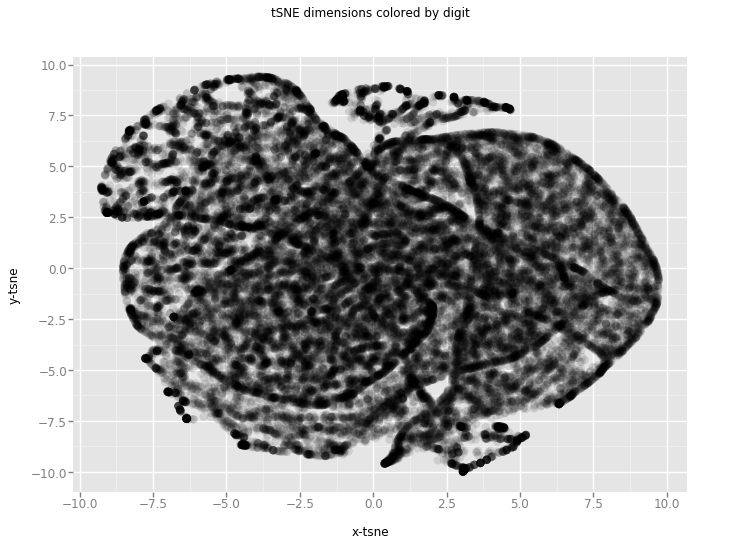

<ggplot: (-9223371869987898280)>

In [69]:
from ggplot import *

df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [ ]:
# TO DO:

#1) Method of building graph : 
    #Based on sessions ? 
    #Include weights if two products are connected multiple times, ie if two products co-occur in multiple queryIDs

In [71]:
df_new = pd.DataFrame(t100)
df_new["itemId"] = idx
df_new.to_pickle("../item_GraphEmbeddings100.pkl")

In [72]:
#Graph Embeddings with 10 iterations
df_new = pd.DataFrame(t2)
df_new["itemId"] = idx
df_new.to_pickle("../item_GraphEmbeddings10.pkl")